# Bibliotecas

In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
pd.options.display.max_columns=1000
import gc
plt.style.use("ggplot")

from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

# Definições

In [112]:
# Operadoras
dicionario=pd.read_excel("C://Users//renjo//Documents//Python//Análise Bases ANS//Arquivos de Apoio//operadoras.xlsx")
operadoras=pd.Series(index=dicionario.CD_OPERADORA.values, data=dicionario.NM_RAZAO_SOCIAL.values)

In [113]:
# Idade
dicionario=pd.read_excel("C://Users//renjo//Documents//Python//Análise Bases ANS//Arquivos de Apoio//Codigos_Tabulação.xlsx",
                         sheet_name="Cod_Faixa_Etária")
faixas_etarias=pd.Series(index=dicionario["Unnamed: 0"].values, data=dicionario.Faixa_Etária.values)

In [114]:
# CNES
# nome
cnes=pd.read_excel("C://Users//renjo//Documents//Python//Bases DATASUS//CNES//Estabelecimentos_SP_Nov24.xlsx")
nome_hosp=pd.Series(index=cnes.CNES.values, data=cnes["NOME FANTASIA"].values)

In [115]:
gde_sp=[355030, 350390, 350570, 350660, 350900,350920, 351060, 351300,
        351380, 351500, 351510, 351570, 351630, 351640, 351830, 351880,
        352220, 352310, 352250, 352500, 352620, 352850, 352940, 353060,
        353440, 353910, 353980, 354330, 354410, 354500, 354680, 354730,
        354780, 354870, 354880, 354995, 355250, 355645, 355280]

# Dados

In [116]:
beneficiarios=pd.read_csv("C://Users//renjo//Documents//Python//Análise Bases ANS//Bases_ANS//Beneficiarios_SP.csv", encoding="latin1", sep=";")
beneficiarios=beneficiarios.iloc[:,1:]
planos=pd.read_csv("C://Users//renjo//Documents//Python//Análise Bases ANS//Bases_ANS//Prestadores_Ativos_SP.csv", encoding="utf-8", sep=";")
planos=planos.iloc[:,1:]

C:\Users\renjo\AppData\Local\Temp\ipykernel_15588\2022540016.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  planos=pd.read_csv("C://Users//renjo//Documents//Python//Análise Bases ANS//Bases_ANS//Prestadores_Ativos_SP.csv", encoding="utf-8", sep=";")


In [117]:
beneficiarios=beneficiarios[beneficiarios.CD_MUNICIPIO.isin(gde_sp)]
planos=planos[planos.Chave.isin(beneficiarios.Chave.unique())]

# Análise Dados

## População e Hospitais no Estado de SP

In [118]:
# Definindo DF com os planos
df=pd.DataFrame(index=planos.Chave.unique())

In [119]:
df["População"]=beneficiarios["QT_BENEFICIARIO_ATIVO"].groupby(beneficiarios.Chave).sum()
df["População"]=df.População.fillna(0)

In [120]:
# Colocando número de hospitais
parcial=planos.drop_duplicates(subset=["CD_CNES", "Chave"])
df["Hospitais"]=parcial.Chave.value_counts()

In [121]:
df

,População,Hospitais
477-000900/025256,1,225
477-001300/000326,3,228
477-001300/015536,1,228
477-000900/029427,16,225
477-001500/000181,1,228
...,...,...
359017-498803245,49,1
411752-105,174,1
420166-435743014,3,1
333051-467970129,287,1


In [122]:
df2=df.População.groupby(df.Hospitais).sum()
df2=pd.DataFrame(df2)
df2["CumSum"]=df2.População.cumsum()
df2["Percentual"]=df2.CumSum/df2.População.sum()

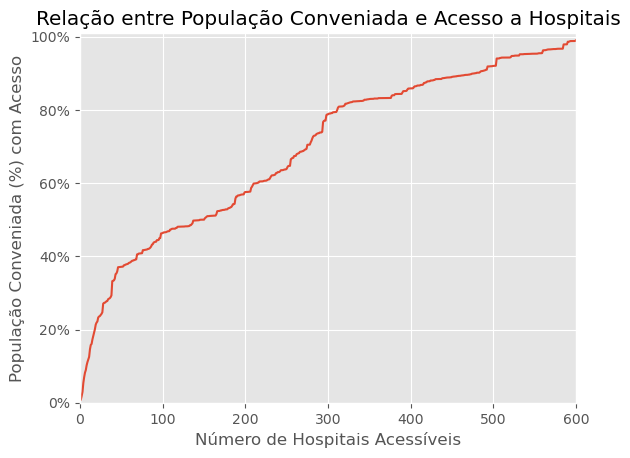

In [123]:
plt.plot(df2.index, df2.Percentual)
plt.xlim(0,600)
plt.ylim(0,1.01)
vals=np.arange(0,1.1,0.2)
plt.yticks(vals, [str(int(x*100))+"%" for x in vals])
plt.title("Relação entre População Conveniada e Acesso a Hospitais")
plt.xlabel("Número de Hospitais Acessíveis")
plt.ylabel("População Conveniada (%) com Acesso")

plt.show()

# Entendendo acesso a equipamentos

In [201]:
equipamentos=pd.read_csv("C://Users//renjo//Documents//Python//Bases DATASUS//CNES//Equipamentos_SP_Out24.csv", sep=";", encoding="latin1")

In [202]:
# Definindo Equipamentos
tabela_eq=pd.DataFrame(index=equipamentos.CNES.unique())

In [203]:
# Incluindo Total de Equipamentos
parcial=equipamentos[equipamentos.CODEQUIP==12]
tabela_eq["Ressonância"]=parcial["QT_EXIST"].groupby(parcial.CNES).sum()
tabela_eq["Ressonância"]=tabela_eq["Ressonância"].fillna(0)

# Incluindo Total de CT
parcial=equipamentos[equipamentos.CODEQUIP==11]
tabela_eq["CT"]=parcial["QT_EXIST"].groupby(parcial.CNES).sum()
tabela_eq["CT"]=tabela_eq["CT"].fillna(0)


# Incluindo Total de Hemodinâmica
parcial=equipamentos[equipamentos.CODEQUIP==10]
tabela_eq["Hemodinâmica"]=parcial["QT_EXIST"].groupby(parcial.CNES).sum()
tabela_eq["Hemodinâmica"]=tabela_eq["Hemodinâmica"].fillna(0)

# Incluindo Total de Hemodiálise
parcial=equipamentos[equipamentos.CODEQUIP==77]
tabela_eq["Hemodiálise"]=parcial["QT_EXIST"].groupby(parcial.CNES).sum()
tabela_eq["Hemodiálise"]=tabela_eq["Hemodiálise"].fillna(0)

In [204]:
tabela_eq.sum()

Ressonância      837.0
CT              3120.0
Hemodinâmica     578.0
Hemodiálise     8929.0
dtype: float64

In [205]:
# Olhando estes dados como disponibilidade
def perfilização(x):
    if x<=70:
        return "Até 70 Hospitais"
    elif x<=300:
        return "de 71 a 300 Hospitais"
    else:
        return "> 300 Hospitais"

df["Perfil"]=df.Hospitais.apply(lambda x: perfilização(x))

In [206]:
# Filtra apenas os registros de planos relevantes
planos_filtrados = planos[planos.Chave.isin(df.index)]

# Cria um mapeamento entre Chave e CD_CNES, considerando apenas os CD_CNES presentes em tabela_eq
mapeamento_hosps = planos_filtrados.groupby("Chave")["CD_CNES"].apply(
    lambda x: [cn for cn in x.unique() if cn in tabela_eq.index]
)

# Inicializa listas de resultados
rnm = []
ct = []
hemod = []
hemodl = []

# Itera sobre as chaves do dataframe principal
for i in tqdm(df.index):
    hosps = mapeamento_hosps.get(i, [])
    tabela = tabela_eq.loc[hosps]
    
    # Calcula os somatórios para cada categoria
    rnm.append(tabela["Ressonância"].sum())
    ct.append(tabela["CT"].sum())
    hemod.append(tabela["Hemodinâmica"].sum())
    hemodl.append(tabela["Hemodiálise"].sum())


100%|███████████████████████████████████████████████████████████████████████████| 11086/11086 [00:32<00:00, 342.43it/s]


In [207]:
df["RNM"]=rnm
df["TC"]=ct
df["Hemodinâmica"]=hemod
df["Hemodiálise"]=hemodl

In [210]:
# Tentando entender Acesso
tabela=pd.DataFrame(index=["Até 70 Hospitais", "de 71 a 300 Hospitais", "> 300 Hospitais"])

In [213]:
# Completando tabela
tabela["Beneficiários"]=df.População.groupby(df.Perfil).sum()

In [225]:
for coluna in ['RNM', 'TC', 'Hemodinâmica','Hemodiálise']:
    for i in tabela.index:
        parcial=df[df.Perfil==i]

        parcial["Produto"]=parcial[coluna]*parcial.População
        tabela.loc[i,coluna]=parcial.Produto.sum()/tabela.loc[i,"Beneficiários"]
        

C:\Users\renjo\AppData\Local\Temp\ipykernel_15588\1841740238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parcial["Produto"]=parcial[coluna]*parcial.População
C:\Users\renjo\AppData\Local\Temp\ipykernel_15588\1841740238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parcial["Produto"]=parcial[coluna]*parcial.População
C:\Users\renjo\AppData\Local\Temp\ipykernel_15588\1841740238.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [227]:
tabela.to_excel("Acesso_Tecnologia.xlsx")